## **DATA PREPROCESSING**: IMAGE SYNTHESIS

From the dataset of _60_ images that we have fetched from the Google Street Views API, we now need to make this dataset as big as we can in order to feed our model

### 0. Imports, globals and requirements

In [7]:
import sys
import os

mounting_folder = "/content/drive/"
root_folder     = "MyDrive/Mejora la red de bici Madrid/"

data_folder     = "data/"
working_folder  = 'data_adquisition_gsm_api/'
metadata_folder = 'gsv_images/'

_pwd = f"{mounting_folder}{root_folder}{working_folder}"
print(f"Running notebook in google colab in : {_pwd}")

Running notebook in google colab in : /content/drive/MyDrive/Mejora la red de bici Madrid/data_adquisition_gsm_api/


In [9]:
%pip install -r "$_pwd"requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import numpy  as np
import pandas as pd
import seaborn as sns


from glob import glob
from os  import path, listdir
from re  import findall
from PIL import Image
from pprint import pprint
from typing import Generator, List
from shapely import wkt

In [12]:
sys.path.append("/content/drive/MyDrive/Mejora la red de bici Madrid/data_adquisition_gsm_api")

### 1. OPENING GOOGLE STREET VIEWER DATA

The images and their metadata have been saved in different files, within the `metadata_folder`. The process of GoogleStreetViewer produces **three** files.

  - <u>header JSON file</u>: has information about the image extraction. 
  The keys that you can find inside are: 
    * Content-Type (what kind of info has been extracted from the API)
    * Date (extraction datetime)
    * Expires
    * Cache-Control
    * Access-Control-Allow-Origin
    * Server
    * Content-Length
    * X-XSS-Protection
    * X-Frame-Options
    * Server-Timing
  - <u>meta JSON file</u>: has metadata related to the image:
    * copyright
    * date
    * location
    * lat
    * lng
    * pano_id
    * status
  - <u>Images as JPG files</u>. JPG files when open either with cv2 or PIL have a colorspace of RGB


---

**NEEDS REVIEW AND FIX**: 

* New extension new images ? 
* Really don't need the header JSON file, so code could be simplified, most of the columns that have any interest are in the meta JSON files
* Could be a bit simpler the parsing, at this moment reads all meta JSONs, merges them, reads all imges, pastes both by the coord chunk of their filename
and creates a dataset with index the img JPG filename.
    * Since IMG and META are different extension, they could be saved with the same name therefore be joined wihout any string transformation.

---

In [13]:
from module.load_data import get_gsv_data



* Loading metadata (JSON files with extra information about the data):
    - this information is separated into two kinds: 'header' and 'meta'
    - locally it is stored at the metadata_folder variable set above `gsv_images`

* Loading the images (JPG files) -> they are saved in the dataframe and the metadata folder `gsv_images`



In [14]:
# PART 0. OPening files in the metadata folder: both imgs and its metadata
# opening the metadata and parsin them as a dict
metadata_folder = f'{_pwd}gsv_imgs/'
metadata = get_gsv_data(gsv_path=metadata_folder)

print(metadata.shape)
print(metadata.index.has_duplicates)

In [17]:
metadata.sort_index(ascending=True).head(2)

,Date,Expires,Content-Length,Server-Timing,copyright,date,location,pano_id,status,coords,image_arr
image_fname,,,,,,,,,,,
pic_40.40505129321862 -3.703332038986189.jpg,"Sun, 22 May 2022 20:38:13 GMT","Mon, 23 May 2022 20:38:13 GMT",65479,gfet4t7; dur=143,© Google,2022-03,"{'lat': 40.40503984096247, 'lng': -3.703359415...",H7luxzGwoPKFiisj794fdA,OK,40.40505129321862_-3.703332038986189,"[[[236, 236, 236], [235, 235, 235], [235, 235,..."
pic_40.406945507000046 -3.711724042999947.jpg,"Sun, 22 May 2022 20:38:38 GMT","Mon, 23 May 2022 20:38:38 GMT",92262,gfet4t7; dur=146,© Google,2022-01,"{'lat': 40.40696520774181, 'lng': -3.711735618...",6w4aWOah78mf9LDyan4mww,OK,40.406945507000046_-3.711724042999947,"[[[168, 205, 250], [168, 205, 250], [168, 205,..."


* Let's check images that are not produced by google.

In [18]:
metadata[metadata['copyright'] != '© Google'].shape

(22, 11)

* Let's check when the images where taken

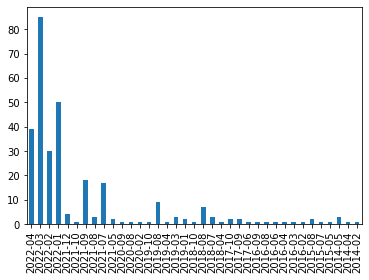

In [19]:
metadata['date'].value_counts().sort_index(ascending=False).plot.bar()

### 2. OPENING THE GEOLOCATED DATASET:

We need to open the geolocated data mainly to fetch the `cyclist_type` column for each image.


The way that this dataset is pasted with the Google Street Viewer data is by the column `img_filename` which is set as in index if both dataframes. 

Once we have pasted both dataframes, we filter to store only the values that we 
need for image pre processing: ['date', 'copyright', 'image_arr', 'geometry', 'cyclist_type'] in `cols_to_take`

---


In [ ]:
from module.load_data import get_geographic_data

In [20]:
df = get_geographic_data(geodf_path=f'{metadata_folder}/', geodf_name='datos_photos')
df.index.has_duplicates

Initial shape: (300, 32)
Shape before droping duplicates and cleaning empty filesnames: (300, 32)	Final shape: (300, 32)
Is dataframe without duplicates: duplicates? False
<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, pic_40.42905954430412 -3.682917274908855.jpg to pic_40.42128581820003 -3.67037943519997.jpg
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          300 non-null    object
 1   copyright     300 non-null    object
 2   image_arr     300 non-null    object
 3   geometry      300 non-null    object
 4   cyclist_type  300 non-null    object
dtypes: object(5)
memory usage: 22.2+ KB


In [ ]:
df = df.join(metadata, how='left')
df.info()

In [21]:
df.index.unique().size == df.index.size

True

In [23]:
df.head(1)

,date,copyright,image_arr,geometry,cyclist_type
img_fname,,,,,
pic_40.42905954430412 -3.682917274908855.jpg,2022-03,© Google,"[[[254, 255, 250], [255, 255, 251], [250, 251,...",POINT (-3.682917274908855 40.42905954430412),Itinerario recomendado


### 3. IMG ANALYSIS:

Before making data augmentation, we need to filter those images that:
 - Were produced by people, therefore they are not images from a cyclist point of view.
 - Noctural images and Tunnel images: they are known not be correctly segment in the model used.


 ----
 Filtra algunos tuneles pero no todos, hace falta revisar los umbrales

In [24]:
from module.filter_imgs import imagearr_to_hsv, imagearr_to_lab, print_color_histogram
from module.filter_imgs import mean_rgb_blue, mean_lab_sat, categorize_if_outlier

#### Inspection of normal vs tunnels images:

We take a list of images that we know that correspond to to different situations:
* Normal images: sunny or images with low contrast, but that are useful (exterior and from a biker standpoint)
* Tunnel images and nocturnal images

In [60]:
"""
Manual inspection on the img folder to see which ones could be interesting to plot
"""

list_of_normal = [
    "pic_40.42990748204791 -3.708493934319486.jpg",
    "pic_40.43029260642903 -3.683695818402983.jpg",
    "pic_40.43029260642903 -3.683695818402983.jpg"
]

list_of_tunnels = [
    "pic_40.42163693971996 -3.712886830986134.jpg", 
    "pic_40.42128581820003 -3.67037943519997.jpg",
    "pic_40.4222841567198 -3.713402040986023.jpg"
]

pic_40.42990748204791 -3.708493934319486.jpg


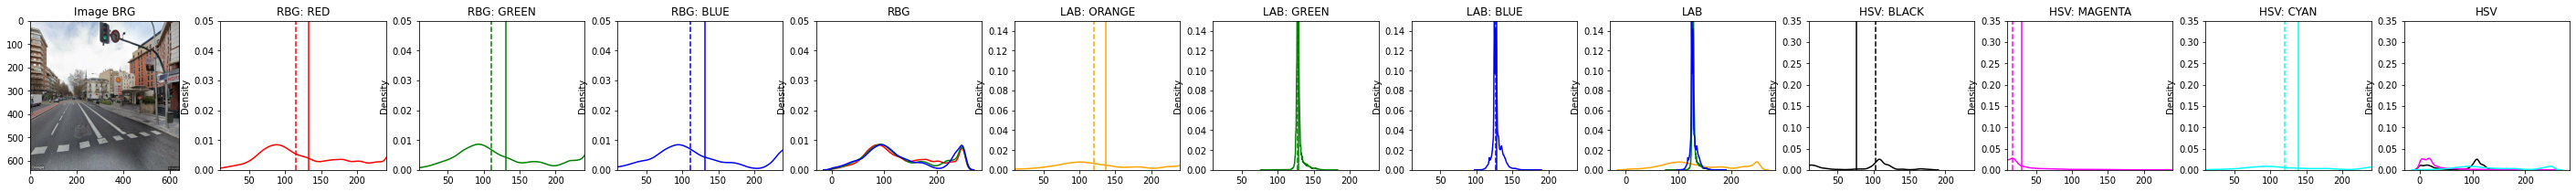

pic_40.43029260642903 -3.683695818402983.jpg


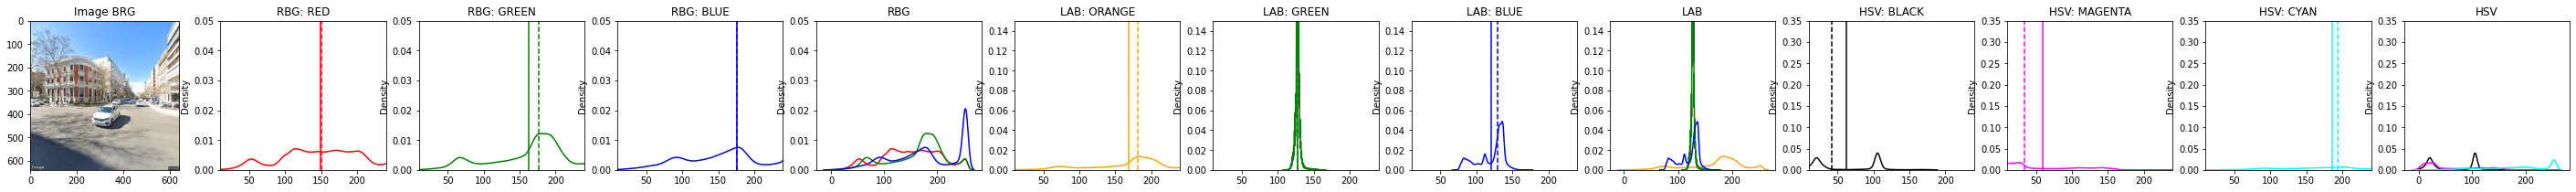

pic_40.43029260642903 -3.683695818402983.jpg


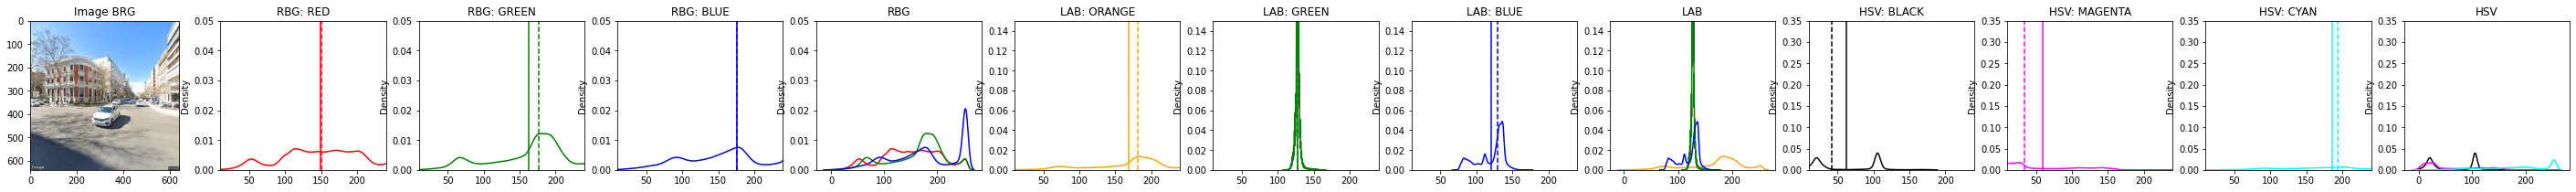

In [35]:
for img in list_of_normal:

    if img in df.index:
        arr = df.loc[img, 'image_arr']    
        print_color_histogram(np.array(arr), figsize=(50,3))
    # end

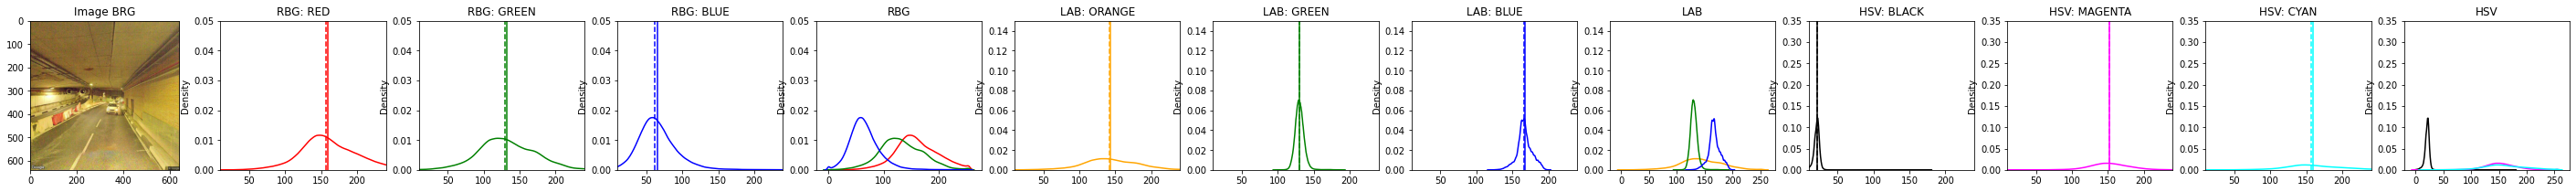

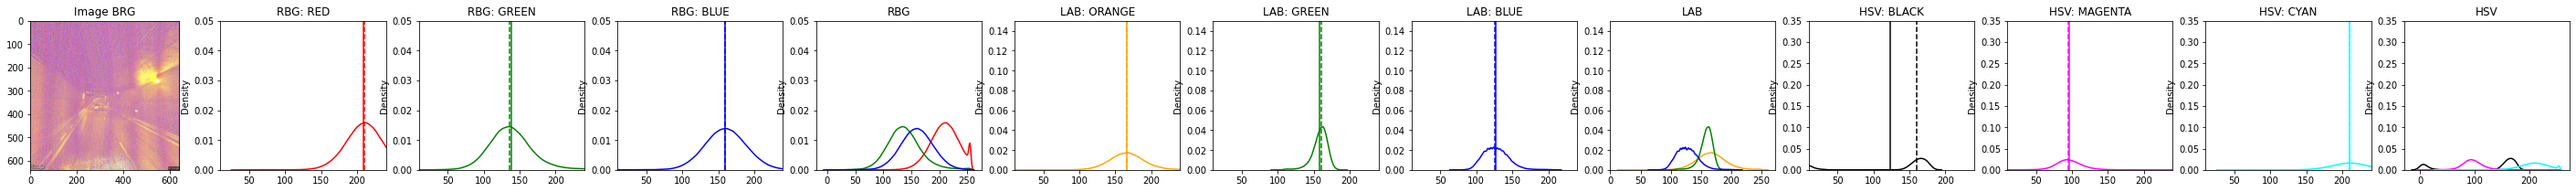

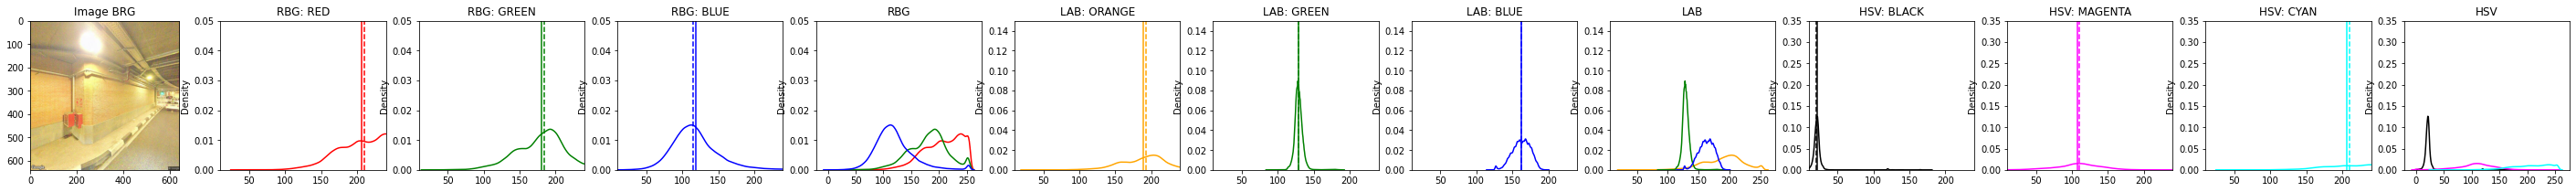

In [61]:
for img in list_of_tunnels:
    if img in df.index:
        arr = df.loc[img, 'image_arr']    
        print_color_histogram(np.array(arr), figsize=(50,3))

* Imprimirmos las medias de los canales azul en RGB y el tono LAB

In [80]:
for img in list_of_normal:   
    arr = df.loc[img, 'image_arr']    
    arr_lab = imagearr_to_lab(arr)
    arr_hsv = imagearr_to_hsv(arr)

    print(f"mean blue: {mean_rgb_blue(arr)}, \tmean hue: {mean_lab_sat(arr_hsv)}")

mean blue: 131.0011669921875, 	mean red: 133.12567626953125, 	mean g2m: 129.10389892578124,  	mean hue: 30.60432861328125
mean blue: 175.549541015625, 	mean red: 149.40101318359376, 	mean g2m: 127.72236083984374,  	mean hue: 60.05831787109375
mean blue: 175.549541015625, 	mean red: 149.40101318359376, 	mean g2m: 127.72236083984374,  	mean hue: 60.05831787109375


In [79]:
for img in list_of_tunnels:   
    arr = df.loc[img, 'image_arr']    
    arr_lab = imagearr_to_lab(arr)
    arr_hsv = imagearr_to_hsv(arr)

    print(f"mean blue: {mean_rgb_blue(arr)}, \tmean hue: {mean_lab_sat(arr_hsv)}")

mean blue: 65.58021240234375, 	mean red: 159.7272802734375, 	mean g2m: 130.48086181640625,  	mean hue: 152.601201171875
mean blue: 160.0790625, 	mean red: 208.92359375, 	mean g2m: 158.5054931640625,  	mean hue: 96.2060693359375
mean blue: 119.08192626953125, 	mean red: 206.0982177734375, 	mean g2m: 129.20336181640624,  	mean hue: 107.6858056640625


#### Create outliers columns and filter them

In [27]:
# create column
df['is_outlier'] = df['image_arr'].apply(categorize_if_outlier)

display(df['is_outlier'].value_counts())

(278, 6)

False    268
True      10
Name: is_outlier, dtype: int64

* Print the outliers

There are 10


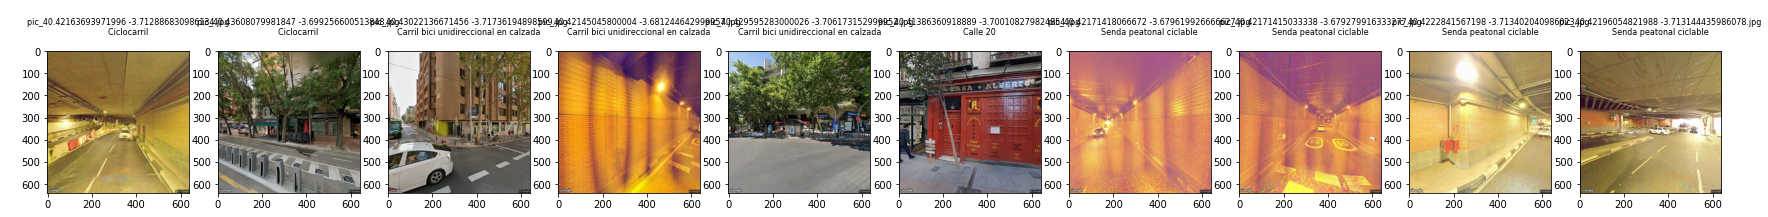

In [84]:
outliers = df[df['is_outlier'] == True]
n_outliers = outliers.shape[0]
print(f"There are {n_outliers}")

f, ax = plt.subplots(ncols = n_outliers, figsize=(3*n_outliers, 3))

for i in range(n_outliers): 
    ax[i].imshow(np.array(outliers['image_arr'].iloc[i]))
    ax[i].set_title(f"""
        {outliers.index[i]}
        {outliers['cyclist_type'].iloc[i]}
    """, fontsize=8)

plt.show()

In [30]:
# filtramos los que son tuneles
df = df[df['is_outlier'] == False].copy(deep=True)
df.shape

(268, 6)

---

### 4. IMG SYNTHESIS

We increase the number of images that we have by applying **DATA AUGMENTATION** with the following preprocessing layers:

- [RandomZoom](!https://keras.io/api/layers/preprocessing_layers/image_preprocessing/random_zoom/): zooms randomly the images by a height and/or width factor; this was though to be usefull to limit how the sky and vegetation is shown; or how the models reads objects that are usully on the frames of the images (people, buildings, etc)
- [RandomContrast:](!https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_contrast/): Saturates or desaturates the images. this may pop up some elements or making them more difficult to segment because their colors are very similar to the objects nearby (f.e: skys)
- [RandomFlip](!https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_flip/):  it randomly flips the image left-to-right so that we can emulate different points of view.
- [RandomBrightness](!https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_brightness/): randomly brightens or darkens the image


----

This part of the process does the following:

- Constructs arrays from the dataframe: 
    * array of imgs 
    * array of file names
    * arrays of classes (cyclist_type)
In order to generate new images the inherit the class and the original filename is not lost through this process

- Create the data augmentation model, by stablishing a SEED variable and assigning parameters to each preprocessing layer. The data augmentation is a Sequential model from keras.

- Iterates through the array of images and creates a new synthetic image from a real image. This is to stablish a ratio of 50:50 on the final dataset and control the data quality, since synthetic images are usually of less data quality than their real counterpart.

- We finally print some random images on a matrix, both the synthetic and its real representation to see how the parameters for the data augmentation are set and have a general idea of what this has produced.

----
 
**FIX:**:
* Sacar al menos 10 img por img real

In [31]:
import tensorflow as tf

In [32]:
# from dataframe to arrays
from collections import defaultdict

def data_to_arrays(frame, cols:list) -> np.ndarray:
    """ Takes some columns from the dataframe and construct different np.ndarray
    
    Args:
        frame: dataframe
    Returns:
        tuple of np.arrays
    """

    # Generamos un diccionario de listas donde insertar elementos de la misma 
    # longitud que nuestro argumento `cols`
    output = defaultdict(list)
    
    # Insertamos el index del dataframe al final (nombre de los archivs)
    # E iteramos sobre las columnas
    # output['index'].append(frame.index.to_numpy())

    for col in cols:
        output[col].append(
            np.stack(frame[col].values)
        )

    # hacemos que las listas sean arrays, en este caso se nos queda un shape:
    # (1, num_images, :, :, 3) por lo que nos quitamos la primera dimension
    output = {k: np.stack(v)[0] for k, v in output.items()}
    return output


####################################
_out = data_to_arrays(frame=df, cols=['image_arr', 'cyclist_type'])

image_arrays    = _out.get('image_arr')
image_label     = _out.get('cyclist_type')

##
print(image_arrays.shape)
print(image_label.shape)

(268, 640, 640, 3)
(268,)


In [33]:
SEED = 40

"""
Image augmentation documentation:
    RandomZoom: https://keras.io/api/layers/preprocessing_layers/image_preprocessing/random_zoom/
    RandomContrast: https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_contrast/
    RandomFlip: https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_flip/
    RandomBrightness: https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_brightness/
"""

zoom_params = {
    'height_factor': (-0.45, 0.45),  # lower and upper bounds to zoom vertically
    'width_factor' : (-0.45, 0.45),  # lower and upper bounds to zoom hortizontally
    'fill_mode': 'constant',         # if there are image gaps, they are fill w/ black(k=0)
    'interpolation': 'bilinear',     # look into this
    'seed': SEED,
}  
contrast_params = {
    'factor': (0., 0.35),  # bounds for factor in: (x - mean) * factor + mean -> [0..1]
    'seed': SEED
}
flip_params = {
    'mode': 'horizontal',  # default to: "horizontal_and_vertical"
    'seed': SEED
}
bright_params = {
    'factor': (-0.1, 0.35),  # factor bounds between [-1..1] -> [black .. white]
    'seed': SEED
}   

data_augmentation = tf.keras.Sequential([
   tf.keras.layers.RandomZoom(**zoom_params),
   tf.keras.layers.RandomContrast(**contrast_params),
   tf.keras.layers.RandomFlip(**flip_params),
   tf.keras.layers.RandomBrightness(**bright_params)
])


* Una vez que tenemos arrays y hemos asignado unos procesos de aumentacion, los aplicamos por cada tipo 

In [34]:
from tqdm import tqdm 

synthetic_images, cyclist_types  = [], []

for i in tqdm(range(len(image_arrays)), desc = 'Progress Bar'): 
    
    image_by_label = image_arrays[i, :, : , :]  # [n img, dim x, dim y, 3 colors]
    img_label = image_label[i]

    for j in range(5):
      
        synth_img = data_augmentation(image_by_label)

        synthetic_images.append(synth_img)
        cyclist_types.append(img_label)


Progress Bar: 100%|██████████| 268/268 [01:06<00:00,  4.02it/s]


In [ ]:
# random 5 images
from random import randrange

n_images = 5
indxs = [randrange(0, len(cyclist_types)) for _ in range(0, n_images)]
l = len(indxs)

f, ax = plt.subplots(nrows = n_images, ncols= 2, figsize=(7,15))

for i in range(0, n_images):
    imput_img = image_arrays[i].astype(np.int64)
    synth_img = np.stack(synthetic_images[i]).astype(np.int64)
    labels = cyclist_types[i]

    ax[i, 0].imshow(imput_img)
    ax[i, 1].imshow(synth_img)

    if i == 0:
        ax[i, 0].set_title('Initial image')    
        ax[i, 1].set_title('Synthetic image')

plt.show()

Finalmente, tenemos que juntas el dataset sintético y el real, flaggeando cuales son reales o creadas, para poder filtrar adecuadamente.

Tb guardamos la clase y el índice de la imagen real, para poder compararlas más adelante.

In [35]:
df['is_real'] = True

In [36]:
# shapes de las cosas que se juntan:
print(df.shape[0])
print(len(synthetic_images))

268
1340


In [37]:
all_images  = [*image_arrays, *synthetic_images]
all_classes = [*df['cyclist_type'].values, *cyclist_types]
all_isReal  = [*[True]*len(image_arrays), *[False]*len(synthetic_images)]
all_geometry = [*df['geometry'].values, *[np.nan]*len(image_arrays)*5]

print(len(all_images))
print(len(all_classes))
print(len(all_isReal))
print(len(all_geometry))

1608
1608
1608
1608


In [32]:
nested_images = [all_images[i: i+100] for i in range(len(all_images), 100)]

---

### 5. IMG NORMALIZATION

Lastly, we need to normalize all images. This process involves:

* Apply [cv2.Normalize](!https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga87eef7ee3970f86906d69a92cbf064bd): it improves the intensity of the image and makes more clear
* Thresholding:
    * Manual threshold  with [cv2.theshold](!) value to the images: that is, values that are very near zero or 255 are mapped into either of them. This makes the image a bit more brighter. 
    * CLAHE over GreysScale imgs, repeating the channel to mantain color compatibility
    * CLAHE over Luminance channel in LAB colorspace, to mantain colors when segmenting the image

In [ ]:
from module.img_normalization import normalize_img_to_bw, normalize_img_to_rgb

#### · Printing an example

In [32]:
i = 22

image_arr = np.asarray(all_images[i]).astype(np.int32)
synth_img = np.asarray(all_images[43+i]).astype(np.int32)

print(image_arr.shape)
print(synth_img.shape)

(640, 640, 3)
(640, 640, 3)


In [ ]:
img_arr, img_clahe, img_norm = normalize_img_to_bw(image_arr)
synth_arr, synth_clahe, synth_norm = normalize_img_to_bw(synth_img)

f, ax = plt.subplots(ncols=6, figsize=(20,3))

ax[0].imshow(img_arr)
ax[1].imshow(img_clahe)
ax[2].imshow(img_norm)

ax[3].imshow(synth_arr)
ax[4].imshow(synth_clahe)
ax[5].imshow(synth_norm)

plt.show()

In [ ]:
img_arr, img_clahe, img_norm = normalize_img_to_rgb(image_arr)
synth_arr, synth_clahe, synth_norm = normalize_img_to_rgb(synth_img)

f, ax = plt.subplots(ncols=6, figsize=(20,3))

ax[0].imshow(img_arr)
ax[1].imshow(img_clahe)
ax[2].imshow(img_norm)

ax[3].imshow(synth_arr)
ax[4].imshow(synth_clahe)
ax[5].imshow(synth_norm)

plt.show()

Once we have deffined the functions let's apply them to all images:

In [ ]:
images_rgb = list(map(normalize_img_to_rgb, all_images))
images_bw  = list(map(normalize_img_to_bw, all_images))

images_rgb = [img for _, _, img in images_rgb]
images_bw  = [img for _, _, img in images_bw]

images_rgb = np.stack(images_rgb)
images_bw  = np.stack(images_bw)

In [44]:
images_bw = []

for i in range(len(all_images)):
    images_bw.append(normalize_img_to_bw(all_images[i, :, :, :]))

In [34]:
bw_data = f"{_pwd}data_augmentation/output_bw/"
bw_imgs = f"{bw_data}jpg/"
fext = '.npy'


if not os.path.exists(bw_data):
    os.makedirs(bw_data)

if not os.path.exists(bw_imgs):
    os.makedirs(bw_imgs)

In [36]:
bw_data = f"{_pwd}data_augmentation/output_bw/"
bw_imgs = f"{bw_data}jpg/"
fext = '.npy'

In [53]:
len(all_images)

1608

In [40]:
j = 200
nested_images = [all_images[i:i+j] for i in range(0, len(all_images), j)]

for i, list_of_images in enumerate(nested_images):
    images_rgb = list(map(normalize_img_to_rgb, list_of_images))

    if isinstance(images_rgb, np.ndarray):
        print(images_rgb.shape)
    else:
        images_rgb = np.stack(images_rgb)
        print(images_rgb.shape)

    np.save(os.path.join(f'images_rgb_part{i}'+'.npy'), images_rgb, allow_pickle=True)

(200, 640, 640, 3)
(200, 640, 640, 3)
(200, 640, 640, 3)
(200, 640, 640, 3)
(200, 640, 640, 3)
(200, 640, 640, 3)
(200, 640, 640, 3)
(200, 640, 640, 3)
(8, 640, 640, 3)


In [ ]:

print(len(all_geometry))

In [43]:
j = 200
nested_classes = [all_geometry[i:i+j] for i in range(0, len(all_geometry), j)]

for i, list_of_elements in enumerate(nested_classes):

    if isinstance(list_of_elements, np.ndarray):
        print(images_bw.shape)
    else:
        list_of_elements = np.stack(list_of_elements)
        print(list_of_elements.shape)

    np.save(os.path.join(f'geometry_part{i}'+'.npy'), list_of_elements, allow_pickle=True)

(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(8,)


In [55]:
type(all_images[0])

numpy.ndarray

In [ ]:
for i, list_of_images in enumerate(nested_images):
    images_bw = list(map(normalize_img_to_rgb, list_of_images))

    for j, img in enumerate(images_bw):
        Image.fromarray(np.array(img, dtype=np.uint8)).save(f'images/i_{str(i*j+1).zfill(5)}.jpg')

In [59]:
for j, img in enumerate(all_images):
    Image.fromarray(np.array(img, dtype=np.uint8)).save(f'images_initial/i_{str(j+1).zfill(5)}.jpg')

In [61]:
from google.colab import files
files.download("/content/images_initial.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
!zip -r /content/images_initial.zip /content/images_initial/*

  adding: content/images_initial/i_00001.jpg (deflated 1%)
  adding: content/images_initial/i_00002.jpg (deflated 1%)
  adding: content/images_initial/i_00003.jpg (deflated 1%)
  adding: content/images_initial/i_00004.jpg (deflated 1%)
  adding: content/images_initial/i_00005.jpg (deflated 1%)
  adding: content/images_initial/i_00006.jpg (deflated 1%)
  adding: content/images_initial/i_00007.jpg (deflated 1%)
  adding: content/images_initial/i_00008.jpg (deflated 0%)
  adding: content/images_initial/i_00009.jpg (deflated 1%)
  adding: content/images_initial/i_00010.jpg (deflated 1%)
  adding: content/images_initial/i_00011.jpg (deflated 0%)
  adding: content/images_initial/i_00012.jpg (deflated 1%)
  adding: content/images_initial/i_00013.jpg (deflated 1%)
  adding: content/images_initial/i_00014.jpg (deflated 1%)
  adding: content/images_initial/i_00015.jpg (deflated 0%)
  adding: content/images_initial/i_00016.jpg (deflated 1%)
  adding: content/images_initial/i_00017.jpg (deflated 1

### 6. SAVE WORK

The information that we haved saved to saved to work is:

* img_arrays
* cyclist_type
* if it is real o synthetic
* geometry as a WKT

----

All the data is saved into `npy` extension, each set of preprocessed images in a different folder. 

Inside the folder, there is also a `jpg/` subfolder with all images saved as a jpg format, to visually check everything is fine.


In [61]:
bw_data = f"{_pwd}data_augmentation/output_bw/"
bw_imgs = f"{bw_data}jpg/"
fext = '.npy'


if not os.path.exists(bw_data):
    os.makedirs(bw_data)

if not os.path.exists(bw_imgs):
    os.makedirs(bw_imgs)

if isinstance(images_bw, np.ndarray):
    print(images_bw.shape)
else:
    images_bw = np.stack(images_bw)
    print(images_bw.shape)

np.save(os.path.join(bw_data, 'images_bw'+'.npy'),         images_bw, allow_pickle=True)
np.save(os.path.join(bw_data, 'cyclist_type'+'.npy'),    all_classes, allow_pickle=True)
np.save(os.path.join(bw_data, 'generated_type'+'.npy'),  all_isReal, allow_pickle=True)

(536, 640, 640, 3)


In [ ]:
bw_data = f"{_pwd}data_augmentation/output_rgb/"
bw_imgs = f"{bw_data}jpg/"

if not os.path.exists(bw_data):
    os.makedirs(bw_data)

if not os.path.exists(bw_imgs):
    os.makedirs(bw_imgs)


np.save(os.path.join(bw_data, 'images_rgb'),     images_rgb, allow_pickle=True)
np.save(os.path.join(bw_data, 'images_pre'),     all_images, allow_pickle=True)
np.save(os.path.join(bw_data, 'cyclist_type'),   all_classes, allow_pickle=True)
np.save(os.path.join(bw_data, 'generated_type'), all_isReal, allow_pickle=True)
np.save(os.path.join(bw_data, 'geolocation_wkt'), all_geometry, allow_pickle=True)


for i, img in enumerate(images_rgb):
    Image.fromarray(img).save(os.path.join(bw_imgs, f'i_{str(i+1).zfill(3)}.jpg'))